# Quora question pairs: training

## Import packages

In [9]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import pandas as pd
import datetime, time, json
from keras.models import Sequential
from keras.layers import Embedding, Dense, Dropout, Reshape, Merge, BatchNormalization, TimeDistributed, Lambda, Concatenate
from keras.regularizers import l2
from keras.callbacks import Callback, ModelCheckpoint
from keras import backend as K
from sklearn.model_selection import train_test_split

## Initialize global variables

In [43]:
Q1_TRAINING_DATA_FILE = '../data/preprocessed/q1_train.npy'
Q2_TRAINING_DATA_FILE = '../data/preprocessed/q2_train.npy'
LABEL_TRAINING_DATA_FILE = '../data/preprocessed/label_train.npy'
Q1_validate_DATA_FILE = '../data/preprocessed/q1_validate.npy'
Q2_validate_DATA_FILE = '../data/preprocessed/q2_validate.npy'
LABEL_validate_DATA_FILE = '../data/preprocessed/label_validate.npy'
Q1_test_DATA_FILE = '../data/preprocessed/q1_test.npy'
Q2_test_DATA_FILE = '../data/preprocessed/q2_test.npy'

WORD_EMBEDDING_MATRIX_FILE = '../data/preprocessed/word_embedding_matrix.npy'
NB_WORDS_DATA_FILE = '../data/preprocessed/nb_words.json'

MODEL_WEIGHTS_FILE = '../data/preprocessed/model_weights.h5'
MODEL_FILE='../data/preprocessed/model.json'
MAX_SEQUENCE_LENGTH = 25
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.1
TEST_SPLIT = 0.1
RNG_SEED = 13371447
NB_EPOCHS = 10

## Load the dataset, embedding matrix and word count

In [6]:
q1_train=np.load(open(Q1_TRAINING_DATA_FILE, 'rb'))
q2_train=np.load(open(Q2_TRAINING_DATA_FILE, 'rb'))
labels_train=np.load(open(LABEL_TRAINING_DATA_FILE, 'rb'))
q1_validate=np.load(open(Q1_validate_DATA_FILE, 'rb'))
q2_validate=np.load(open(Q2_validate_DATA_FILE, 'rb'))
labels_validate=np.load(open(LABEL_validate_DATA_FILE, 'rb'))
q1_test=np.load(open(Q1_test_DATA_FILE, 'rb'))
q2_test=np.load(open(Q2_test_DATA_FILE, 'rb'))
word_embedding_matrix=np.load(open(WORD_EMBEDDING_MATRIX_FILE, 'rb'))
with open(NB_WORDS_DATA_FILE, 'r') as f:
    num_words = json.load(f)['nb_words']


## Define the model

In [33]:
Q1 = Sequential()
Q1.add(Embedding(num_words + 1, 
                 EMBEDDING_DIM, 
                 weights=[word_embedding_matrix], 
                 input_length=MAX_SEQUENCE_LENGTH, 
                 trainable=False))
Q1.add(TimeDistributed(Dense(EMBEDDING_DIM, activation='relu')))
Q1.add(Lambda(lambda x: K.max(x, axis=1), output_shape=(EMBEDDING_DIM, )))
Q2 = Sequential()
Q2.add(Embedding(num_words + 1, 
                 EMBEDDING_DIM, 
                 weights=[word_embedding_matrix], 
                 input_length=MAX_SEQUENCE_LENGTH, 
                 trainable=False))
Q2.add(TimeDistributed(Dense(EMBEDDING_DIM, activation='relu')))
Q2.add(Lambda(lambda x: K.max(x, axis=1), output_shape=(EMBEDDING_DIM, )))
model = Sequential()
model.add(Merge([Q1, Q2], mode="concat"))
model.add(BatchNormalization())
model.add(Dense(200, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(200, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(200, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(200, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

/Users/jingyi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:18: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


## Train the model, checkpointing weights with best validation accuracy

In [36]:
print("Starting training at", datetime.datetime.now())
t0 = time.time()
callbacks = [ModelCheckpoint(MODEL_WEIGHTS_FILE, monitor='val_loss', save_best_only=True)]
history = model.fit([q1_train, q2_train],
                    labels_train,
                    epochs=NB_EPOCHS,
                    validation_split=VALIDATION_SPLIT,
                    verbose=2,
                    callbacks=callbacks)
t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2017-05-02 08:23:02.724801
Train on 291088 samples, validate on 32344 samples
Epoch 1/10
501s - loss: 0.5144 - acc: 0.7408 - val_loss: 0.4633 - val_acc: 0.7716
Epoch 2/10
483s - loss: 0.4509 - acc: 0.7803 - val_loss: 0.4331 - val_acc: 0.7911
Epoch 3/10
479s - loss: 0.4130 - acc: 0.8030 - val_loss: 0.4146 - val_acc: 0.7997
Epoch 4/10
469s - loss: 0.3858 - acc: 0.8193 - val_loss: 0.4059 - val_acc: 0.8050
Epoch 5/10
468s - loss: 0.3618 - acc: 0.8327 - val_loss: 0.3964 - val_acc: 0.8128
Epoch 6/10
481s - loss: 0.3399 - acc: 0.8448 - val_loss: 0.4034 - val_acc: 0.8159
Epoch 7/10
484s - loss: 0.3209 - acc: 0.8555 - val_loss: 0.3950 - val_acc: 0.8192
Epoch 8/10
467s - loss: 0.3038 - acc: 0.8650 - val_loss: 0.3984 - val_acc: 0.8165
Epoch 9/10
467s - loss: 0.2919 - acc: 0.8708 - val_loss: 0.4122 - val_acc: 0.8175
Epoch 10/10
480s - loss: 0.2793 - acc: 0.8769 - val_loss: 0.4173 - val_acc: 0.8155
Training ended at 2017-05-02 09:42:50.477308
Minutes elapsed: 79.795866


## Plot training and validation accuracy

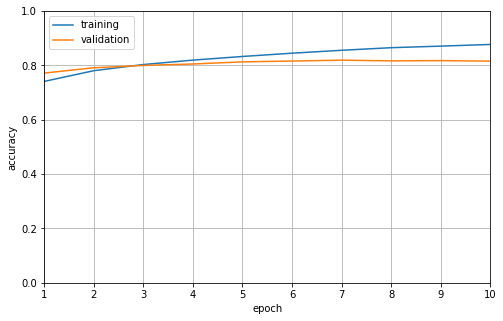

In [37]:
acc = pd.DataFrame({'epoch': [ i + 1 for i in history.epoch ],
                    'training': history.history['acc'],
                    'validation': history.history['val_acc']})
ax = acc.ix[:,:].plot(x='epoch', figsize={5,8}, grid=True)
ax.set_ylabel("accuracy")
ax.set_ylim([0.0,1.0]);

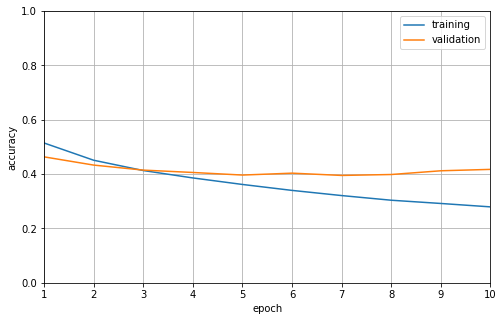

In [38]:
acc = pd.DataFrame({'epoch': [ i + 1 for i in history.epoch ],
                    'training': history.history['loss'],
                    'validation': history.history['val_loss']})
ax = acc.ix[:,:].plot(x='epoch', figsize={5,8}, grid=True)
ax.set_ylabel("accuracy")
ax.set_ylim([0.0,1.0]);

## Print best validation accuracy and epoch

In [39]:
min_val_loss, idx = min((val, idx) for (idx, val) in enumerate(history.history['val_loss']))
print('Min val_loss at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(min_val_loss))

Min val_loss at epoch 7 = 0.3950


In [40]:
max_val_acc, idx_acc = max((val, idx) for (idx, val) in enumerate(history.history['val_acc']))
print('Maximum accuracy at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(max_val_acc))

Maximum accuracy at epoch 7 = 0.8192


## Evaluate the model with best validation accuracy on the test partition

In [41]:
model.load_weights(MODEL_WEIGHTS_FILE)
loss, accuracy= model.evaluate([q1_validate, q2_validate], labels_validate)
print('')
print('loss      = {0:.4f}'.format(loss))
print('accuracy  = {0:.4f}'.format(accuracy))


80858/80858 [==============================] - 28s     

In [44]:
model_json = model.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)